In [1]:
import cv2
import torch
import glob, os, sys
import matplotlib.pyplot as plt
import numpy as np

print("PyTorch version: ", torch.__version__)
print("PyTorch with CUDA support:", torch.cuda.is_available())
print("OpenCV version", cv2.__version__)
print("NumPy version: ", np.__version__)

import ipdreader

PyTorch version:  2.3.1+cu121
PyTorch with CUDA support: False
OpenCV version 4.11.0
NumPy version:  2.1.1


/home/joao/source/SAM-6D/sam6d-venv/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
SHORTER_SIDE = 720
IPD_DATASET_ROOT_DIR = "/mnt/061A31701A315E3D/ipd-dataset/bpc_baseline/datasets"

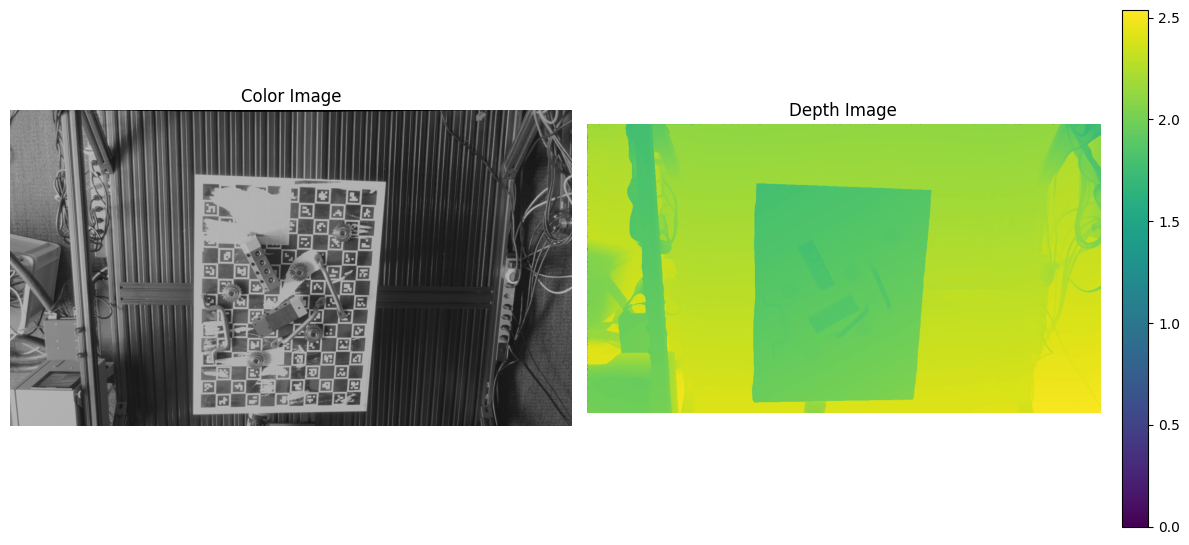

In [3]:
reader = ipdreader.IpdReader(root_folder=IPD_DATASET_ROOT_DIR, shorter_side=SHORTER_SIDE)

group_id, scene_id, camera_id = 10, 0, 1

color = reader.get_rgb_image(group_id, scene_id, camera_id)
depth = reader.get_depth_image(group_id, scene_id, camera_id)
K = reader.get_camera_intrinsics_K_matrix(group_id, scene_id, camera_id)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the color image
axes[0].imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Color Image")
axes[0].axis("off")

# Display the depth image
depth_display = axes[1].imshow(depth, cmap='viridis')
axes[1].set_title("Depth Image")
axes[1].axis("off")

# Add a colorbar for the depth image
fig.colorbar(depth_display, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In the depth image, each pixel value corresponds to the distance to the camera, in meters.

Now, I want you to produce the code cell that would follow the one above.

I can see several planes with the naked eye: the room floor, a tray, etc. 
Using RANSAC, fit several 3D planes to the depth image, in a iterative manner, as follows. 
Fit as many 3D planes as you can, one per iteration. At each iteration, fit the next 3D plane using solely the remaining pixels not yet fitted to previous planes.

There are two tunable hyperparameters in this process.
1. Depth pixel inlier threshold. The admissible difference between a depth pixel value and the candidate 3D plane being fitted. Start with a value of 0.01, corresponding to 0.01 meters.
2. The count of inlier pixels belonging to the candidate 3D plane being fitted. A 3D plane is only accepted and added to the collection of found planes if it is large enough, i.e., the amount of inliers is above a certain threshold. The latter is another tunable hyperparameter. Start with a value of 10% of the image area (to be independent of input depth image resolution).

Starting iterative RANSAC plane fitting...
Image size: 1280x720 = 921600 pixels
Inlier threshold: 0.015 meters
Minimum inlier ratio: 10.00%
Minimum required inliers per plane: 92160
Initial number of valid pixels: 921453

--- Iteration 1 ---
Fitting RANSAC on 921453 remaining pixels...
RANSAC found a potential plane with 427428 inliers.
Plane 1 found: z = 0.0000x + 0.0004y + 2.1042
Removed 427428 inliers. Pixels remaining: 494025

--- Iteration 2 ---
Fitting RANSAC on 494025 remaining pixels...
RANSAC found a potential plane with 202323 inliers.
Plane 2 found: z = 0.0002x + 0.0004y + 1.6328
Removed 202323 inliers. Pixels remaining: 291702

--- Iteration 3 ---
Fitting RANSAC on 291702 remaining pixels...
RANSAC found a potential plane with 97476 inliers.
Plane 3 found: z = 0.0000x + 0.0004y + 2.1851
Removed 97476 inliers. Pixels remaining: 194226

--- Iteration 4 ---
Fitting RANSAC on 194226 remaining pixels...
RANSAC found a potential plane with 46608 inliers.
Stopping: Found plane has

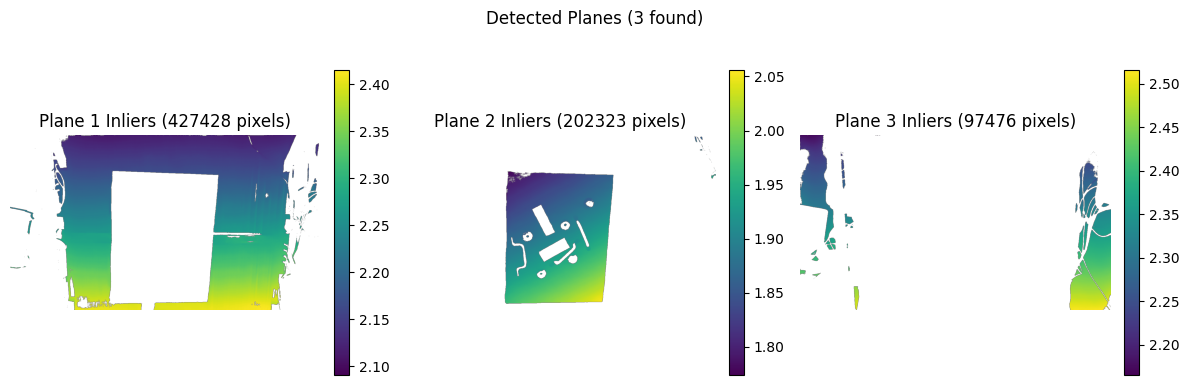

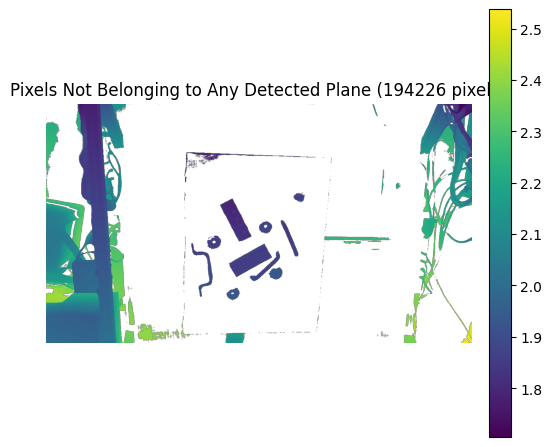

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import cv2 # Assuming cv2 is needed from previous cell

# Custom 3D plane model for RANSAC
# This model fits a plane of the form z = ax + by + c
# where (x, y) are pixel coordinates and z is the depth value.
class PlaneModel(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        # X is Nx2 array of (x, y) pixel coordinates
        # y is Nx1 array of depth values
        # We need at least 3 points to define a plane
        if X.shape[0] < 3:
            # Not enough points to fit a plane, return without fitting
            # Set dummy coefficients to avoid errors later
            self.coef_ = np.zeros(2)
            self.intercept_ = 0
            return self

        # Append a column of ones to X for the intercept term c
        A = np.c_[X, np.ones(X.shape[0])]
        try:
            # Solve the linear system Az = y for plane coefficients [a, b, c]
            # Using lstsq for robustness
            coeffs, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
            self.coef_ = coeffs[:2] # a, b
            self.intercept_ = coeffs[2] # c
        except np.linalg.LinAlgError:
            # Handle cases where lstsq fails (e.g., collinear points)
            # Set dummy coefficients
            self.coef_ = np.zeros(2)
            self.intercept_ = 0
        return self

    def predict(self, X):
        # Predict depth (z) values for given (x, y) coordinates using the fitted plane
        # z = ax + by + c
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        # RANSAC uses the residual threshold, but a score function is needed.
        # We can use a simple metric like negative mean absolute error.
        # Or simply return 1 since RANSAC focuses on the inlier count.
        return 1.0 # Placeholder score

def fit_planes_ransac(depth, inlier_threshold=0.01, min_inlier_ratio=0.1):
    """
    Iteratively fits 3D planes to a depth image using RANSAC.

    Args:
        depth (np.ndarray): The input depth image (HxW).
        inlier_threshold (float): Maximum distance (in meters) for a point to be
                                  considered an inlier to the plane.
        min_inlier_ratio (float): Minimum fraction of total pixels required
                                  to form a valid plane.

    Returns:
        tuple: A tuple containing:
            - list: List of fitted plane parameters [(a, b, c), ...].
            - list: List of boolean masks (HxW) indicating inliers for each plane.
    """
    height, width = depth.shape
    min_inliers = int(min_inlier_ratio * height * width)

    # Create a grid of pixel coordinates (x, y)
    # Note: Using matrix indexing ('ij') so x corresponds to columns, y to rows
    yy, xx = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    # Flatten the coordinates and depth values
    pixels = np.c_[xx.ravel(), yy.ravel()] # Shape: (H*W, 2)
    depth_values = depth.ravel() # Shape: (H*W,)

    # Mask to keep track of pixels not yet assigned to a plane
    # Initially, all valid depth pixels are available
    # Exclude pixels with invalid depth (e.g., NaN or 0, depending on sensor)
    valid_depth_mask = np.isfinite(depth_values) & (depth_values > 0) # Adjust if 0 is valid depth
    remaining_mask = valid_depth_mask.copy()

    planes = []
    inlier_masks_list = []

    print(f"Starting iterative RANSAC plane fitting...")
    print(f"Image size: {width}x{height} = {height*width} pixels")
    print(f"Inlier threshold: {inlier_threshold} meters")
    print(f"Minimum inlier ratio: {min_inlier_ratio*100:.2f}%")
    print(f"Minimum required inliers per plane: {min_inliers}")
    print(f"Initial number of valid pixels: {np.sum(remaining_mask)}")

    iteration = 0
    while True:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")

        # Select only the remaining valid pixels for fitting
        current_pixels = pixels[remaining_mask]
        current_depths = depth_values[remaining_mask]

        # Check if enough points are left to potentially form a plane
        if len(current_depths) < min_inliers:
            print(f"Stopping: Not enough remaining pixels ({len(current_depths)}) to meet minimum inlier count ({min_inliers}).")
            break

        print(f"Fitting RANSAC on {len(current_depths)} remaining pixels...")

        try:
            # Configure and run RANSAC
            ransac = RANSACRegressor(
                estimator=PlaneModel(),
                min_samples=3,  # Minimum 3 points to define a plane
                residual_threshold=inlier_threshold,
                max_trials=1000, # Number of RANSAC iterations
                stop_probability=0.99, # Stop early if confident
                random_state=42 # for reproducibility
            )
            ransac.fit(current_pixels, current_depths)
        except ValueError as e:
             # This can happen if min_samples is larger than the number of available points
             print(f"RANSAC fitting failed: {e}. Stopping.")
             break

        # Check if a model was successfully fitted (RANSAC might fail if no inliers found)
        if not hasattr(ransac, 'estimator_'):
             print("RANSAC failed to find a model in this iteration. Stopping.")
             break

        # Get the mask of inliers *within the current subset* of points
        current_inlier_mask = ransac.inlier_mask_
        num_inliers = np.sum(current_inlier_mask)

        print(f"RANSAC found a potential plane with {num_inliers} inliers.")

        # Check if the number of inliers meets the minimum requirement
        if num_inliers < min_inliers:
            print(f"Stopping: Found plane has only {num_inliers} inliers, less than the required {min_inliers}.")
            break

        # Valid plane found! Store its parameters and mask
        plane_params = (ransac.estimator_.coef_[0], # a
                        ransac.estimator_.coef_[1], # b
                        ransac.estimator_.intercept_) # c
        planes.append(plane_params)
        print(f"Plane {len(planes)} found: z = {plane_params[0]:.4f}x + {plane_params[1]:.4f}y + {plane_params[2]:.4f}")

        # Create the full-size inlier mask for this plane
        # Start with a False mask of the same shape as remaining_mask
        full_inlier_mask = np.zeros_like(remaining_mask, dtype=bool)
        # Find the indices of the remaining pixels
        remaining_indices = np.where(remaining_mask)[0]
        # Find the indices of the inliers *within* the remaining pixels
        inlier_indices_in_subset = np.where(current_inlier_mask)[0]
        # Map these subset indices back to the original flat array indices
        inlier_indices_global = remaining_indices[inlier_indices_in_subset]
        # Set these global indices to True in the full mask
        full_inlier_mask[inlier_indices_global] = True

        # Reshape to image dimensions and add to list
        inlier_masks_list.append(full_inlier_mask.reshape(height, width))

        # Update the remaining_mask: remove the inliers found in this iteration
        remaining_mask[full_inlier_mask] = False
        print(f"Removed {num_inliers} inliers. Pixels remaining: {np.sum(remaining_mask)}")

        # Optional: Stop if remaining pixels are too few
        if np.sum(remaining_mask) < min_inliers:
             print(f"Stopping: Not enough remaining pixels ({np.sum(remaining_mask)}) for next iteration.")
             break

    print(f"\nFinished fitting. Found {len(planes)} planes.")
    return planes, inlier_masks_list

# --- Parameters ---
# Depth pixel inlier threshold (meters)
# A pixel is considered an inlier if its distance to the plane is less than this value.
inlier_threshold_meters = 0.015

# Minimum required number of inlier pixels to accept a plane, as a ratio of total pixels.
# Helps filter out small or spurious planes.
min_inlier_ratio_percent = 0.10 # 10%

# --- Run the Plane Fitting ---
# Assuming the 'depth' variable is loaded from the previous cell
planes_found, plane_inlier_masks = fit_planes_ransac(
    depth,
    inlier_threshold=inlier_threshold_meters,
    min_inlier_ratio=min_inlier_ratio_percent
)

# --- Visualization of Detected Plane Inliers ---
num_planes = len(planes_found)
if num_planes > 0:
    fig_planes, axes_planes = plt.subplots(1, num_planes, figsize=(4 * num_planes, 4))
    if num_planes == 1:
        axes_planes = [axes_planes] # Make it iterable for the loop

    for i, mask in enumerate(plane_inlier_masks):
        # Create a display image: original depth where mask is true, NaN otherwise
        plane_viz = np.full(depth.shape, np.nan)
        plane_viz[mask] = depth[mask]

        im = axes_planes[i].imshow(plane_viz, cmap='viridis') # Use same cmap as original depth display
        axes_planes[i].set_title(f"Plane {i+1} Inliers ({np.sum(mask)} pixels)")
        axes_planes[i].axis('off')
        fig_planes.colorbar(im, ax=axes_planes[i], fraction=0.046, pad=0.04)

    plt.suptitle(f"Detected Planes ({num_planes} found)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()
else:
    print("No planes were detected with the current parameters.")

# --- Optional: Visualize remaining points ---
if num_planes > 0:
    # Combine all masks to see which pixels belong to *any* plane
    all_plane_masks = np.zeros(depth.shape, dtype=bool)
    for mask in plane_inlier_masks:
        all_plane_masks = np.logical_or(all_plane_masks, mask)

    # Create visualization for remaining points
    remaining_depth_viz = np.full(depth.shape, np.nan)
    # Consider only initially valid pixels that were not assigned to any plane
    valid_mask_2d = (np.isfinite(depth) & (depth > 0)) # Recreate 2D valid mask
    remaining_pixels_mask = valid_mask_2d & (~all_plane_masks)
    remaining_depth_viz[remaining_pixels_mask] = depth[remaining_pixels_mask]

    plt.figure(figsize=(6, 6))
    plt.imshow(remaining_depth_viz, cmap='viridis')
    plt.title(f"Pixels Not Belonging to Any Detected Plane ({np.sum(remaining_pixels_mask)} pixels)")
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

--- Calculating Features for Each Plane ---

Analyzing Plane 1...
  AABB Size (X,Y,Z): 2.195m, 1.229m, 0.324m
  OBB Approx Size (L,W,D via PCA): 2.164m, 1.390m, 0.049m
  Metric Size Check (80-150cm): False
  Compactness (Inliers / Hull Area): 1.0061
  Internal Outlier Ratio (vs hull area): 0.0038
  Num 'Objects on Top' (closer outliers): 487
  Average Depth: 2.238m
  Normal Vector (approx): [0.043, 0.198, -0.979]
  Normal Angle wrt Vertical Axis (0=VertNorm/HorizPlane, 90=HorizNorm/VertPlane): 78.6 degrees
  Plane Tilt from Horizontal Plane (0=Horizontal, 90=Vertical): 11.4 degrees
  Is Approx Horizontal (Tilt <= 30.0 deg): True
  Centroid Distance from Camera: 2.241m

Analyzing Plane 2...
  AABB Size (X,Y,Z): 1.275m, 1.003m, 0.282m
  OBB Approx Size (L,W,D via PCA): 1.115m, 1.233m, 0.039m
  Metric Size Check (80-150cm): True
  Compactness (Inliers / Hull Area): 0.9096
  Internal Outlier Ratio (vs hull area): 0.1002
  Num 'Objects on Top' (closer outliers): 22284
  Average Depth: 1.908

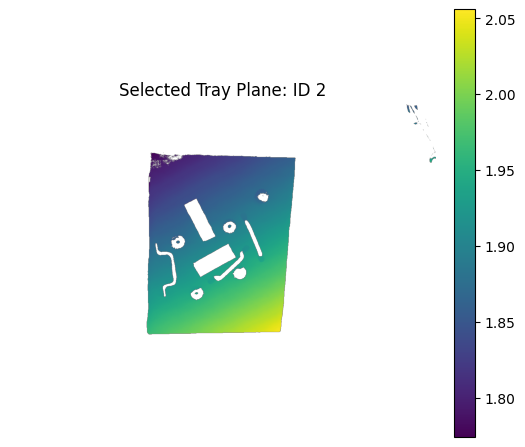

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # For convex hull, findContours
from sklearn.decomposition import PCA # For OBB approximation
# Assuming scipy is available for Rotation if more advanced normal analysis is needed,
# but the current method doesn't strictly require it.
# from scipy.spatial.transform import Rotation as R

# --- Assume previous variables are available from the RANSAC step ---
# depth: HxW depth image (result from reader.get_depth_image)
# K: 3x3 camera intrinsics matrix (result from reader.get_camera_intrinsics_K_matrix)
# planes_found: List of plane parameters (a, b, c) from RANSAC
# plane_inlier_masks: List of HxW boolean masks from RANSAC
# inlier_threshold_meters: The threshold used in RANSAC (e.g., 0.01)

# --- Prepare Data Structure ---
detected_planes_info = []
for i, (params, mask) in enumerate(zip(planes_found, plane_inlier_masks)):
    detected_planes_info.append({
        'id': i + 1,
        'params': params, # (a, b, c) from PlaneModel z = ax_pix + by_pix + c
        'mask': mask,     # HxW boolean mask
        'num_inliers': np.sum(mask)
        # Other metrics will be added below
    })

# Extract camera intrinsics for 3D conversion
fx = K[0, 0]
fy = K[1, 1]
cx = K[0, 2]
cy = K[1, 2]

# --- Calculate Features for Each Detected Plane ---
print("--- Calculating Features for Each Plane ---")
for plane_info in detected_planes_info:
    mask = plane_info['mask']
    params = plane_info['params']
    plane_id = plane_info['id']
    num_inliers = plane_info['num_inliers']

    print(f"\nAnalyzing Plane {plane_id}...")

    # Initialize fields to avoid errors if calculations fail
    plane_info['points_3d'] = np.empty((0, 3))
    plane_info['aabb_size_xyz'] = np.array([0,0,0])
    plane_info['obb_approx_size_lwd'] = np.array([0,0,0])
    plane_info['metric_size_ok'] = False
    plane_info['internal_outlier_ratio'] = 0.0
    plane_info['num_objects_on_top'] = 0
    plane_info['compactness'] = 0.0
    plane_info['average_depth'] = np.inf
    plane_info['normal_vector'] = None
    plane_info['normal_angle_wrt_vertical'] = None
    plane_info['plane_tilt_from_horizontal'] = None
    plane_info['is_horizontal_flag'] = None
    plane_info['centroid_3d'] = None
    plane_info['distance_from_camera'] = np.inf

    # Get pixel coordinates (u, v) and depth values (z) of inliers
    inlier_coords_v, inlier_coords_u = np.where(mask) # v = row (y), u = col (x)
    if len(inlier_coords_v) == 0:
        print("  Skipping plane with zero inliers.")
        continue

    inlier_depths = depth[inlier_coords_v, inlier_coords_u]

    # --- 1. Calculate 3D Point Cloud and Metric Size ---
    # Convert inlier pixel coordinates (u,v) and depth (z) to 3D points (X, Y, Z)
    X = (inlier_coords_u - cx) * inlier_depths / fx
    Y = (inlier_coords_v - cy) * inlier_depths / fy
    Z = inlier_depths
    inlier_points_3d = np.vstack((X, Y, Z)).T # Shape: (N, 3)
    plane_info['points_3d'] = inlier_points_3d

    if inlier_points_3d.shape[0] >= 3:
        # Method A: Axis-Aligned Bounding Box (AABB) size in 3D
        min_coords = np.min(inlier_points_3d, axis=0)
        max_coords = np.max(inlier_points_3d, axis=0)
        aabb_dimensions = max_coords - min_coords
        plane_info['aabb_size_xyz'] = aabb_dimensions
        print(f"  AABB Size (X,Y,Z): {aabb_dimensions[0]:.3f}m, {aabb_dimensions[1]:.3f}m, {aabb_dimensions[2]:.3f}m")

        # Method B: Oriented Bounding Box (OBB) approximation using PCA on 3D points
        try:
            pca = PCA(n_components=3)
            pca.fit(inlier_points_3d)
            points_transformed = pca.transform(inlier_points_3d)
            min_coords_pca = np.min(points_transformed, axis=0)
            max_coords_pca = np.max(points_transformed, axis=0)
            obb_dimensions = max_coords_pca - min_coords_pca
            plane_info['obb_approx_size_lwd'] = obb_dimensions
            print(f"  OBB Approx Size (L,W,D via PCA): {obb_dimensions[0]:.3f}m, {obb_dimensions[1]:.3f}m, {obb_dimensions[2]:.3f}m")

            # CORRECTED Metric Size Check with updated range
            dim1, dim2 = sorted(obb_dimensions[:2], reverse=True) # Length and Width
            min_allowed_dim = 0.80 # 80 cm
            max_allowed_dim = 1.50 # 150 cm
            is_size_ok = (min_allowed_dim <= dim1 <= max_allowed_dim) and \
                         (min_allowed_dim <= dim2 <= max_allowed_dim)
            plane_info['metric_size_ok'] = is_size_ok
            print(f"  Metric Size Check ({min_allowed_dim*100:.0f}-{max_allowed_dim*100:.0f}cm): {is_size_ok}")

        except Exception as e:
            print(f"  PCA failed for size calculation: {e}")
            # Keep default values assigned earlier

    else:
        print("  Not enough points for size calculation.")


    # --- 2. Calculate "Internal Outlier" Ratio and Compactness ---
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
      print("  No contours found for mask, skipping internal outlier/compactness check.")
      # Keep defaults
    else:
      largest_contour = max(contours, key=cv2.contourArea)
      hull_mask = np.zeros_like(mask, dtype=np.uint8)
      cv2.drawContours(hull_mask, [largest_contour], -1, 1, thickness=cv2.FILLED)
      hull_area_pixels = np.sum(hull_mask)

      if hull_area_pixels > 0:
          # Calculate Compactness
          compactness = num_inliers / hull_area_pixels
          plane_info['compactness'] = compactness
          print(f"  Compactness (Inliers / Hull Area): {compactness:.4f}")

          # Calculate Internal Outliers
          hull_coords_v, hull_coords_u = np.where(hull_mask)
          depths_inside_hull = depth[hull_coords_v, hull_coords_u]
          valid_mask_inside_hull = np.isfinite(depths_inside_hull) & (depths_inside_hull > 0)

          if np.any(valid_mask_inside_hull):
            valid_hull_coords_u = hull_coords_u[valid_mask_inside_hull]
            valid_hull_coords_v = hull_coords_v[valid_mask_inside_hull]
            valid_depths_inside_hull = depths_inside_hull[valid_mask_inside_hull]

            plane_a, plane_b, plane_c = params
            predicted_depths_inside_hull = plane_a * valid_hull_coords_u + plane_b * valid_hull_coords_v + plane_c
            depth_diff = np.abs(valid_depths_inside_hull - predicted_depths_inside_hull)

            # Outliers based on RANSAC threshold
            internal_outliers_mask = depth_diff > inlier_threshold_meters
            num_internal_outliers = np.sum(internal_outliers_mask)
            internal_outlier_ratio = num_internal_outliers / hull_area_pixels
            plane_info['internal_outlier_ratio'] = internal_outlier_ratio
            print(f"  Internal Outlier Ratio (vs hull area): {internal_outlier_ratio:.4f}")

            # Specifically count points closer than the plane (objects on top)
            objects_on_top_mask = (predicted_depths_inside_hull - valid_depths_inside_hull) > inlier_threshold_meters
            num_objects_on_top = np.sum(objects_on_top_mask)
            plane_info['num_objects_on_top'] = num_objects_on_top
            print(f"  Num 'Objects on Top' (closer outliers): {num_objects_on_top}")
          else:
              print("  No valid depth points found within the hull mask.")
      else:
          print("  Hull area is zero, skipping internal outlier and compactness calculation.")


    # --- 3. Calculate Average Depth ---
    if num_inliers > 0:
        avg_depth = np.mean(inlier_depths)
        plane_info['average_depth'] = avg_depth
        print(f"  Average Depth: {avg_depth:.3f}m")
    # else: Keep default np.inf


    # --- 4. Calculate Plane Normal and Orientation ---
    if inlier_points_3d.shape[0] >= 3:
      try:
        center_idx = inlier_points_3d.shape[0] // 2
        idx0, idx1, idx2 = 0, center_idx, inlier_points_3d.shape[0] - 1
        # Basic check for distinct points
        if not (idx0 < idx1 < idx2):
             # Fallback if too few points for distinct indices
             indices = np.linspace(0, inlier_points_3d.shape[0] - 1, 3, dtype=int)
             idx0, idx1, idx2 = indices[0], indices[1], indices[2]
             if len(set([idx0, idx1, idx2])) < 3: # Check again after linspace
                 raise ValueError("Cannot find 3 distinct points")

        p0, p1, p2 = inlier_points_3d[idx0], inlier_points_3d[idx1], inlier_points_3d[idx2]
        v1, v2 = p1 - p0, p2 - p0
        normal = np.cross(v1, v2)
        norm_mag = np.linalg.norm(normal)
        if norm_mag < 1e-6: raise ValueError("Collinear points")
        normal /= norm_mag

        # Assuming standard camera coordinates (+X right, +Y down, +Z forward/depth)
        # Normal should point towards the camera (negative Z direction)
        if normal[2] > 0: normal = -normal
        plane_info['normal_vector'] = normal

        # Calculate Angle of Normal wrt Vertical (Y-down)
        vertical_vector = np.array([0, 1, 0])
        dot_product_clipped = np.clip(np.dot(normal, vertical_vector), -1.0, 1.0)
        normal_angle_wrt_vertical_raw = np.degrees(np.arccos(dot_product_clipped))
        normal_angle_wrt_vertical = min(normal_angle_wrt_vertical_raw, 180.0 - normal_angle_wrt_vertical_raw)
        plane_info['normal_angle_wrt_vertical'] = normal_angle_wrt_vertical

        # Calculate Plane Tilt from Horizontal
        plane_tilt_from_horizontal = 90.0 - normal_angle_wrt_vertical
        plane_info['plane_tilt_from_horizontal'] = plane_tilt_from_horizontal

        # Set is_horizontal_flag based on tilt
        max_allowed_tilt_for_horizontal_flag = 30.0
        is_horizontal = plane_tilt_from_horizontal <= max_allowed_tilt_for_horizontal_flag
        plane_info['is_horizontal_flag'] = is_horizontal

        # Print results with clear interpretation
        print(f"  Normal Vector (approx): [{normal[0]:.3f}, {normal[1]:.3f}, {normal[2]:.3f}]")
        print(f"  Normal Angle wrt Vertical Axis (0=VertNorm/HorizPlane, 90=HorizNorm/VertPlane): {normal_angle_wrt_vertical:.1f} degrees")
        print(f"  Plane Tilt from Horizontal Plane (0=Horizontal, 90=Vertical): {plane_tilt_from_horizontal:.1f} degrees")
        print(f"  Is Approx Horizontal (Tilt <= {max_allowed_tilt_for_horizontal_flag:.1f} deg): {is_horizontal}")

      except ValueError as e:
          print(f"  Normal calculation failed: {e}")
          # Keep defaults

    # else: Keep defaults for not enough points


    # --- 5. Calculate Centroid and Distance ---
    if num_inliers > 0 and inlier_points_3d.shape[0] > 0:
       centroid_3d = np.mean(inlier_points_3d, axis=0)
       plane_info['centroid_3d'] = centroid_3d
       plane_info['distance_from_camera'] = np.linalg.norm(centroid_3d)
       print(f"  Centroid Distance from Camera: {plane_info['distance_from_camera']:.3f}m")
    # else: Keep defaults


# --- Apply Filters and Select the Best Plane ---
candidate_planes = []
print("\n--- Applying Filters (Corrected Angle/Size Logic) ---")

# Filter thresholds
min_required_inlier_ratio_filter = 0.05
min_required_inliers_filter = int(min_required_inlier_ratio_filter * depth.shape[0] * depth.shape[1])
min_compactness_filter = 0.6
max_allowed_tilt_filter = 30.0 # Max deviation of plane from horizontal (degrees)
enable_metric_size_filter = True # Use updated range (0.8-1.5m) checked during feature calc
enable_internal_outlier_filter = True
min_internal_outlier_ratio_filter = 0.05 # Require >= 5% outlier pixels within hull
min_objects_on_top_filter = 1000       # Require >= 1000 pixels closer than the plane


for plane in detected_planes_info:
    plane_id = plane['id']
    print(f"\nEvaluating Plane {plane_id}:")
    passed_all = True # Flag

    # Filter 1: Minimum Size (Inliers)
    if plane['num_inliers'] < min_required_inliers_filter:
      print(f"  REJECTED (Filter 1): Too few inliers ({plane['num_inliers']} < {min_required_inliers_filter})")
      passed_all = False
    else:
      print(f"  PASSED (Filter 1): Size OK ({plane['num_inliers']} >= {min_required_inliers_filter})")

    # Filter 2: Compactness
    if not passed_all: continue
    compactness = plane.get('compactness', 0)
    # Check for potentially buggy high compactness values
    if compactness > 1.1:
        print(f"  WARNING (Filter 2): Compactness {compactness:.3f} > 1.1, unusual. Capping check at 1.1.")
        compactness = 1.1 # Cap for threshold check purpose
    if compactness < min_compactness_filter:
      print(f"  REJECTED (Filter 2): Not compact ({plane.get('compactness', 0):.3f} < {min_compactness_filter})")
      passed_all = False
    else:
      print(f"  PASSED (Filter 2): Compactness OK ({plane.get('compactness', 0):.3f} >= {min_compactness_filter})")

    # Filter 3: Orientation based on Tilt
    if not passed_all: continue
    plane_tilt = plane.get('plane_tilt_from_horizontal', 90.0) # Default to vertical if missing
    if plane_tilt is None: # Handle case where calculation failed
        print(f"  REJECTED (Filter 3): Tilt angle not available.")
        passed_all = False
    elif plane_tilt > max_allowed_tilt_filter:
       print(f"  REJECTED (Filter 3): Too tilted (Tilt: {plane_tilt:.1f} deg > {max_allowed_tilt_filter:.1f} deg)")
       passed_all = False
    else:
       print(f"  PASSED (Filter 3): Tilt OK (Tilt: {plane_tilt:.1f} deg <= {max_allowed_tilt_filter:.1f} deg)")

    # Filter 4: Metric Size (Using pre-calculated flag with updated range)
    if not passed_all: continue
    if enable_metric_size_filter:
        metric_size_ok = plane.get('metric_size_ok', False)
        if not metric_size_ok:
           print(f"  REJECTED (Filter 4): Metric size incorrect (Dims: {plane.get('obb_approx_size_lwd', [0,0,0])[:2]})")
           passed_all = False
        else:
           print(f"  PASSED (Filter 4): Metric Size OK")
    else:
        print(f"  SKIPPED (Filter 4): Metric Size check disabled.")

    # Filter 5: Internal Outliers / Objects on Top
    if not passed_all: continue
    if enable_internal_outlier_filter:
        internal_outlier_ratio = plane.get('internal_outlier_ratio', 0)
        num_objects_on_top = plane.get('num_objects_on_top', 0)
        ratio_ok = internal_outlier_ratio >= min_internal_outlier_ratio_filter
        count_ok = num_objects_on_top >= min_objects_on_top_filter
        if not (ratio_ok or count_ok):
             print(f"  REJECTED (Filter 5): Insufficient internal outliers/objects (Ratio: {internal_outlier_ratio:.4f} < {min_internal_outlier_ratio_filter} OR Count: {num_objects_on_top} < {min_objects_on_top_filter})")
             passed_all = False
        else:
             print(f"  PASSED (Filter 5): Sufficient internal outliers/objects (Ratio: {internal_outlier_ratio:.4f}, Count: {num_objects_on_top})")
    else:
         print(f"  SKIPPED (Filter 5): Internal outlier check disabled.")

    # Add to candidates if all enabled filters passed
    if passed_all:
        print(f"---> Plane {plane_id} ACCEPTED as candidate.")
        candidate_planes.append(plane)


# --- Select the Best Candidate (e.g., closest) ---
selected_plane = None
if not candidate_planes:
    print("\nNo planes passed all filters.")
elif len(candidate_planes) == 1:
    selected_plane = candidate_planes[0]
    print(f"\nSelected the only candidate: Plane {selected_plane['id']}")
else:
    print(f"\nMultiple candidates found ({len(candidate_planes)}): {[p['id'] for p in candidate_planes]}")
    candidate_distances = {p['id']: p.get('distance_from_camera', np.inf) for p in candidate_planes}
    print(f"  Candidate distances from camera: {candidate_distances}")
    # Using proximity to select the best candidate
    selected_plane = min(candidate_planes, key=lambda p: p.get('distance_from_camera', np.inf))
    print(f"\nSelected Plane {selected_plane['id']} (closest candidate with distance {selected_plane.get('distance_from_camera', np.inf):.3f}m)")


# --- Display the Selected Plane ---
if selected_plane:
    plt.figure(figsize=(6, 6))
    plane_viz = np.full(depth.shape, np.nan)
    mask_selected = selected_plane['mask']
    # Filter depth values for visualization using the mask
    valid_depths_selected = depth[mask_selected]
    # Ensure there are valid depth values before calculating vmin/vmax
    if valid_depths_selected.size > 0 and np.any(np.isfinite(valid_depths_selected)):
        vmin = np.nanmin(valid_depths_selected)
        vmax = np.nanmax(valid_depths_selected)
    else:
        vmin, vmax = None, None # Fallback if no valid points

    plane_viz[mask_selected] = valid_depths_selected # Apply mask correctly
    im = plt.imshow(plane_viz, cmap='viridis', vmin=vmin, vmax=vmax) # Adjust vmin/vmax
    plt.title(f"Selected Tray Plane: ID {selected_plane['id']}")
    plt.axis('off')
    plt.colorbar(im, fraction=0.046, pad=0.04) # Use the image handle 'im' for colorbar
    plt.show()
else:
    print("\nCould not automatically select the tray plane based on the final criteria.")




--- Fitting 2D Oriented Bounding Box (OBB) to Plane 2 ---
OBB Found:
  Center (u, v): (629.76, 427.77)
  Size (w, h): (438.22, 543.30) pixels
  Angle: 1.76 degrees
  Corners:
[[402.3985  692.5507 ]
 [419.10736 149.51102]
 [857.1235  162.98846]
 [840.4146  706.0282 ]]


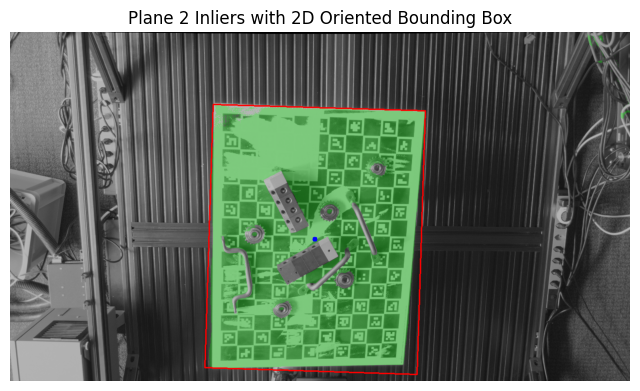

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # For minAreaRect, findContours, boxPoints, pointPolygonTest

# --- Assume variables from previous cells are available ---
# selected_plane: Dictionary with info about the chosen tray plane (ID, params, mask, etc.)
# depth: The original depth image (used for visualization context)
# color: The original color image (used for visualization context, can be None if unavailable)

if selected_plane:
    print(f"\n--- Fitting 2D Oriented Bounding Box (OBB) to Plane {selected_plane['id']} ---")

    plane_mask = selected_plane['mask'] # HxW boolean mask for Plane 2

    # Ensure mask is 8-bit format for OpenCV functions
    mask_uint8 = plane_mask.astype(np.uint8)

    # Find contours of the plane mask. We expect one main contour.
    contours, hierarchy = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Assume the largest contour corresponds to the main tray surface
        largest_contour = max(contours, key=cv2.contourArea)

        # Find the minimum area rotated rectangle bounding this contour
        # rect = ((center_x, center_y), (width, height), angle)
        rect = cv2.minAreaRect(largest_contour)

        # Get the 4 corner points of the rotated box
        # box is a Float32 array of shape (4, 2) containing (x,y) coordinates
        box_corners = cv2.boxPoints(rect)
        box_corners_int = np.intp(box_corners) # Convert to integer points for drawing

        # Store OBB information
        obb_info = {
            'center': rect[0],      # (x, y) float tuple
            'size': rect[1],        # (width, height) float tuple
            'angle': rect[2],       # Angle float
            'corners': box_corners  # (4, 2) float array
        }

        print(f"OBB Found:")
        print(f"  Center (u, v): ({obb_info['center'][0]:.2f}, {obb_info['center'][1]:.2f})")
        print(f"  Size (w, h): ({obb_info['size'][0]:.2f}, {obb_info['size'][1]:.2f}) pixels")
        print(f"  Angle: {obb_info['angle']:.2f} degrees") # Note: OpenCV angle definition might need interpretation depending on use case [10]
        print(f"  Corners:\n{box_corners}")

        # --- Visualization ---
        # Create an image to draw on. Use color image if available, else create one.
        if 'color' in locals() and color is not None and color.shape[:2] == plane_mask.shape:
            vis_image = cv2.cvtColor(color, cv2.COLOR_BGR2RGB) if len(color.shape) == 3 and color.shape[2] == 3 else color.copy()
            # Overlay plane mask slightly transparently
            vis_image[plane_mask] = vis_image[plane_mask] * 0.7 + np.array([0, 255, 0], dtype=vis_image.dtype) * 0.3 # Green tint
        else: # Fallback: create a black image and draw mask
            vis_image = np.zeros((*plane_mask.shape, 3), dtype=np.uint8)
            vis_image[plane_mask] = [0, 100, 0] # Dark green for mask

        # Draw the OBB polygon
        cv2.drawContours(vis_image, [box_corners_int], 0, (255, 0, 0), 2) # Draw red box

        # Draw the center point
        center_int = (int(obb_info['center'][0]), int(obb_info['center'][1]))
        cv2.circle(vis_image, center_int, 5, (0, 0, 255), -1) # Draw blue center

        plt.figure(figsize=(8, 8))
        plt.imshow(vis_image)
        plt.title(f"Plane {selected_plane['id']} Inliers with 2D Oriented Bounding Box")
        plt.axis('off')
        plt.show()

        # --- Filtering Function Definition ---
        # This function can be used later to check if points are inside the OBB
        def is_point_inside_obb(point_uv, obb_corners_float):
            """
            Checks if a 2D point (u, v) is inside the oriented bounding box.
            Args:
                point_uv (tuple or list): The (u, v) coordinates of the point.
                obb_corners_float (np.ndarray): The (4, 2) float array of OBB corner points.
            Returns:
                bool: True if the point is inside or on the boundary, False otherwise.
            """
            # cv2.pointPolygonTest requires contour points in int or float32
            # It returns +1 (inside), -1 (outside), or 0 (on vertex/edge)
            result = cv2.pointPolygonTest(obb_corners_float.astype(np.float32),
                                          tuple(map(float, point_uv)),
                                          measureDist=False) # We only need inside/outside status
            return result >= 0 # True if inside or on the boundary

        # Example Usage (demonstration - you would call this later)
        # test_point = (obb_info['center'][0], obb_info['center'][1]) # The center should be inside
        # print(f"\nIs center point {test_point} inside OBB? {is_point_inside_obb(test_point, box_corners)}")
        # test_point_outside = (0, 0) # Origin likely outside
        # print(f"Is point (0,0) inside OBB? {is_point_inside_obb(test_point_outside, box_corners)}")

    else:
        print(f"No contours found for the mask of Plane {selected_plane['id']}. Cannot fit OBB.")
        obb_info = None # Indicate OBB was not found

else:
    print("No plane was selected in the previous step. Cannot fit OBB.")
    obb_info = None




--- Refining Plane Fit for Tray (Plane 2) using RANSAC ---
Found 201863 valid points within initial Plane 2 mask and its OBB.
Running RANSAC refinement with threshold = 0.0070 m...
Refined RANSAC found plane: Z = 0.1348*X + 0.2519*Y + 1.8925
Number of refined inliers: 193963 / 201863


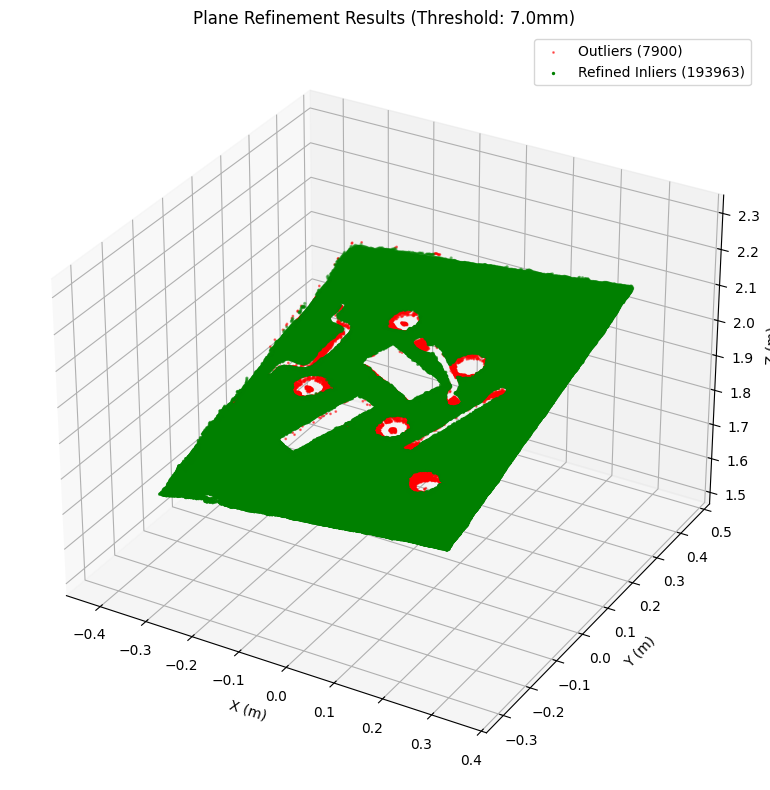

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # For pointPolygonTest
from sklearn.linear_model import RANSACRegressor
# Assuming PlaneModel is defined as in previous steps (fitting Z = a*X + b*Y + c)
# If not, include its definition here:
from sklearn.base import BaseEstimator, RegressorMixin
class PlaneModel(BaseEstimator, RegressorMixin):
    def fit(self, X, y): # X is Nx2 [X, Y], y is N [Z]
        if X.shape[0] < 3:
            self.coef_ = np.zeros(2)
            self.intercept_ = 0
            return self
        A = np.c_[X, np.ones(X.shape[0])]
        try:
            coeffs, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
            self.coef_ = coeffs[:2] # a, b
            self.intercept_ = coeffs[2] # c
        except np.linalg.LinAlgError:
            self.coef_ = np.zeros(2)
            self.intercept_ = 0
        return self
    def predict(self, X): # X is Mx2 [X, Y]
        return X @ self.coef_ + self.intercept_
    def score(self, X, y): return 1.0 # Placeholder
    def get_params(self, deep=True): return {}
    def set_params(self, **parameters): return self


# --- Assume variables from previous steps are available ---
# selected_plane: Dictionary with info about the initial Plane 2 fit
# obb_info: Dictionary with OBB info ('corners') for Plane 2 mask
# depth: The original depth image
# K: Camera intrinsics matrix

# --- Refined Plane Fitting ---
refined_plane_info = None
points_for_refinement_3d = np.empty((0,3))
refined_inliers_mask = np.array([], dtype=bool)

if selected_plane and obb_info:
    print(f"\n--- Refining Plane Fit for Tray (Plane {selected_plane['id']}) using RANSAC ---")

    # --- 1. Select Candidate Points (Plane 2 Inliers within OBB) ---
    initial_plane_mask = selected_plane['mask']
    obb_corners = obb_info['corners'] # (4, 2) float array

    # Get (u, v) coordinates of initial inliers
    initial_inlier_v, initial_inlier_u = np.where(initial_plane_mask)

    # Check which initial inliers are inside the OBB
    points_to_check_uv = list(zip(initial_inlier_u, initial_inlier_v))

    # **** CORRECTED LINE ****
    is_inside_obb_mask = np.array([
        cv2.pointPolygonTest(obb_corners.astype(np.float32), tuple(map(float, pt)), False) >= 0
        for pt in points_to_check_uv
    ], dtype=bool)
    # **** END CORRECTION ****

    # Get the (u, v, depth) of points inside both the initial mask and the OBB
    refined_candidate_u = initial_inlier_u[is_inside_obb_mask]
    refined_candidate_v = initial_inlier_v[is_inside_obb_mask]

    # Ensure coordinates are valid before accessing depth array
    if len(refined_candidate_u) > 0:
      refined_candidate_depth = depth[refined_candidate_v, refined_candidate_u]

      # Filter out any invalid depth values
      valid_depth_final_mask = np.isfinite(refined_candidate_depth) & (refined_candidate_depth > 0)
      final_candidate_u = refined_candidate_u[valid_depth_final_mask]
      final_candidate_v = refined_candidate_v[valid_depth_final_mask]
      final_candidate_depth = refined_candidate_depth[valid_depth_final_mask]
    else:
      # Handle case where no points were inside OBB
      final_candidate_u = np.array([], dtype=int)
      final_candidate_v = np.array([], dtype=int)
      final_candidate_depth = np.array([], dtype=float)


    num_candidates = len(final_candidate_u)
    print(f"Found {num_candidates} valid points within initial Plane 2 mask and its OBB.")

    # --- 2. Convert to 3D ---
    if num_candidates > 3: # Need at least 3 points to fit a plane
        fx = K[0, 0]; fy = K[1, 1]; cx = K[0, 2]; cy = K[1, 2]
        X_coords = (final_candidate_u - cx) * final_candidate_depth / fx
        Y_coords = (final_candidate_v - cy) * final_candidate_depth / fy
        Z_coords = final_candidate_depth
        points_for_refinement_3d = np.vstack((X_coords, Y_coords, Z_coords)).T # Shape: (N, 3)

        # --- 3. Run RANSAC (Refinement) ---
        refined_threshold_meters = 0.01 # e.g., 2 millimeters

        print(f"Running RANSAC refinement with threshold = {refined_threshold_meters:.4f} m...")
        try:
            ransac_refined = RANSACRegressor(
                estimator=PlaneModel(),
                min_samples=3,
                residual_threshold=refined_threshold_meters,
                max_trials=1000,
                stop_probability=0.99,
                random_state=42
            )
            ransac_refined.fit(points_for_refinement_3d[:, :2], points_for_refinement_3d[:, 2])

            # --- 4. Extract Results ---
            if hasattr(ransac_refined, 'estimator_') and ransac_refined.estimator_ is not None and hasattr(ransac_refined, 'inlier_mask_'):
                refined_params = (ransac_refined.estimator_.coef_[0], # a
                                  ransac_refined.estimator_.coef_[1], # b
                                  ransac_refined.estimator_.intercept_) # c
                refined_inliers_mask = ransac_refined.inlier_mask_ # Boolean mask for points_for_refinement_3d
                num_refined_inliers = np.sum(refined_inliers_mask)

                print(f"Refined RANSAC found plane: Z = {refined_params[0]:.4f}*X + {refined_params[1]:.4f}*Y + {refined_params[2]:.4f}")
                print(f"Number of refined inliers: {num_refined_inliers} / {num_candidates}")

                refined_plane_info = {
                    'params': refined_params,
                    'inlier_mask_indices': np.where(refined_inliers_mask)[0],
                    'num_inliers': num_refined_inliers,
                    'threshold': refined_threshold_meters
                }
            else:
                print("Refined RANSAC failed to find a model or inlier mask.")
                refined_inliers_mask = np.zeros(num_candidates, dtype=bool)

        except ValueError as e:
             print(f"Refined RANSAC fitting failed: {e}")
             refined_inliers_mask = np.zeros(num_candidates, dtype=bool)
    else:
        print("Not enough candidate points found within OBB for RANSAC refinement.")
        refined_inliers_mask = np.zeros(num_candidates, dtype=bool) # Ensure mask exists but is empty

    # --- 5. Visualize Refinement Results ---
    if points_for_refinement_3d.shape[0] > 0:
        fig_refine = plt.figure(figsize=(10, 8))
        ax_refine = fig_refine.add_subplot(111, projection='3d')

        points_input = points_for_refinement_3d
        inlier_points = points_input[refined_inliers_mask]
        outlier_points = points_input[~refined_inliers_mask]

        if outlier_points.shape[0] > 0:
            ax_refine.scatter(outlier_points[:, 0], outlier_points[:, 1], outlier_points[:, 2],
                              c='red', s=1, alpha=0.5, label=f'Outliers ({outlier_points.shape[0]})')
        if inlier_points.shape[0] > 0:
             ax_refine.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2],
                               c='green', s=2, label=f'Refined Inliers ({inlier_points.shape[0]})')

        ax_refine.set_xlabel('X (m)'); ax_refine.set_ylabel('Y (m)'); ax_refine.set_zlabel('Z (m)')
        ax_refine.set_title(f"Plane Refinement Results (Threshold: {refined_threshold_meters*1000:.1f}mm)") # Show threshold in mm

        # Set equal aspect ratio
        center = np.mean(points_input, axis=0)
        try: # Handle cases where all points might be identical
             max_range = (np.nanmax(points_input, axis=0) - np.nanmin(points_input, axis=0)).max() / 2.0 + 0.05
             if not np.isfinite(max_range) or max_range <= 0.05: max_range = 0.5 # Fallback range
        except:
             max_range = 0.5 # Fallback range

        ax_refine.set_xlim(center[0] - max_range, center[0] + max_range)
        ax_refine.set_ylim(center[1] - max_range, center[1] + max_range)
        ax_refine.set_zlim(center[2] - max_range, center[2] + max_range)

        # Ensure legend is shown only if labels were added
        handles, labels = ax_refine.get_legend_handles_labels()
        if handles:
            ax_refine.legend()

        plt.tight_layout()
        plt.show()

    else:
        print("No points available to visualize for refinement.")

else:
    print("Initial selected plane or OBB info not available. Cannot perform refinement.")



--- Creating Masks from Refined Plane Fit ---
Mapping 193963 refined plane inliers back to 2D mask.
Mapping 7900 object/outlier points back to 2D mask.


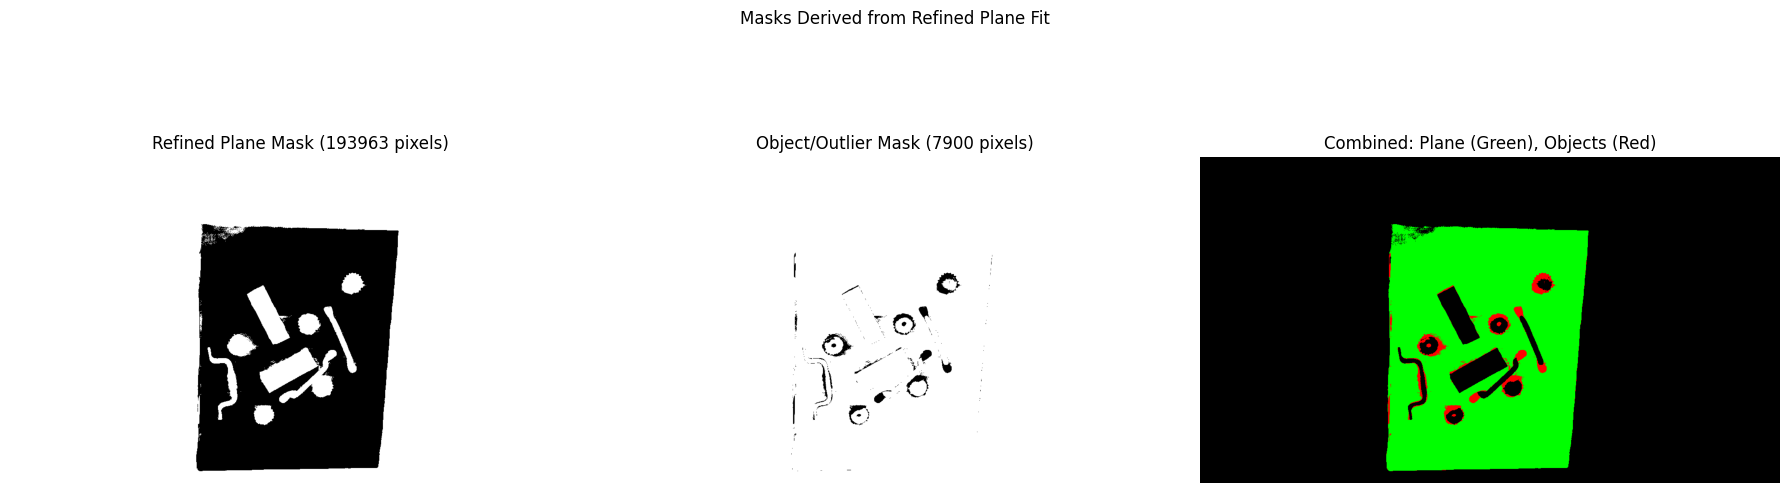

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Only needed potentially for visualization, not core logic

# --- Assume variables from the previous RANSAC refinement step are available ---
# points_for_refinement_3d: (N, 3) array of 3D points used as input for refinement.
# refined_inliers_mask: Boolean mask (length N) indicating inliers in points_for_refinement_3d.
# final_candidate_u: (N,) array of original u-coordinates corresponding to points_for_refinement_3d.
# final_candidate_v: (N,) array of original v-coordinates corresponding to points_for_refinement_3d.
# depth: The original HxW depth image (for shape and visualization context).

print("\n--- Creating Masks from Refined Plane Fit ---")

# Initialize full-size boolean masks
height, width = depth.shape
refined_plane_mask_2d = np.zeros((height, width), dtype=bool)
object_outlier_mask_2d = np.zeros((height, width), dtype=bool)

# Check if the refinement step produced valid results
if 'refined_inliers_mask' in locals() and refined_inliers_mask.size == len(final_candidate_u):

    # --- 1. Identify coordinates of refined inliers ---
    refined_inlier_u = final_candidate_u[refined_inliers_mask]
    refined_inlier_v = final_candidate_v[refined_inliers_mask]
    num_inliers = len(refined_inlier_u)
    print(f"Mapping {num_inliers} refined plane inliers back to 2D mask.")

    # Populate the refined plane mask
    if num_inliers > 0:
        refined_plane_mask_2d[refined_inlier_v, refined_inlier_u] = True

    # --- 2. Identify coordinates of outliers from refinement ---
    outlier_mask_1d = ~refined_inliers_mask
    refined_outlier_u = final_candidate_u[outlier_mask_1d]
    refined_outlier_v = final_candidate_v[outlier_mask_1d]
    num_outliers = len(refined_outlier_u)
    print(f"Mapping {num_outliers} object/outlier points back to 2D mask.")

    # Populate the object/outlier mask
    if num_outliers > 0:
        object_outlier_mask_2d[refined_outlier_v, refined_outlier_u] = True

    # --- 3. Visualize the resulting masks ---
    fig_masks, axes_masks = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Refined Plane Inliers Mask
    axes_masks[0].imshow(refined_plane_mask_2d, cmap='binary')
    axes_masks[0].set_title(f"Refined Plane Mask ({num_inliers} pixels)")
    axes_masks[0].axis('off')

    # Plot Object/Outlier Mask
    axes_masks[1].imshow(object_outlier_mask_2d, cmap='binary')
    axes_masks[1].set_title(f"Object/Outlier Mask ({num_outliers} pixels)")
    axes_masks[1].axis('off')

    # Plot combined/overlay (optional)
    # Create an image showing background, refined plane, and objects
    vis_combined = np.zeros((height, width, 3), dtype=np.uint8)
    # vis_combined[:, :] = [50, 50, 50] # Dark grey background (optional)
    vis_combined[refined_plane_mask_2d] = [0, 255, 0] # Green for refined plane
    vis_combined[object_outlier_mask_2d] = [255, 0, 0] # Red for objects/outliers

    axes_masks[2].imshow(vis_combined)
    axes_masks[2].set_title("Combined: Plane (Green), Objects (Red)")
    axes_masks[2].axis('off')


    plt.suptitle("Masks Derived from Refined Plane Fit")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # You can now use refined_plane_mask_2d and object_outlier_mask_2d for further processing.

else:
    print("Refined RANSAC results ('refined_inliers_mask') not found or incompatible. Cannot create filtered masks.")
    # Ensure masks are defined even if empty
    refined_plane_mask_2d = np.zeros((height, width), dtype=bool)
    object_outlier_mask_2d = np.zeros((height, width), dtype=bool)



1249.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


DEPRECATION: Loading egg at /home/joao/source/SAM-6D/sam6d-venv/lib/python3.12/site-packages/pointnet2-0.0.0-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

--- Detecting Objects on Selected Plane (ID: 2) ---
Found 2116 potential object points initially above the plane.
Applying erosion filter to remove edge points...
Removed 1711 points via erosion filter. 405 points remaining.
Applying Radius Outlier Removal filter...
Removed 12 points via Radius Outlier Removal. 393 points remaining for clustering.

Clustering FILTERED object points using DBSCAN...
DBSCAN found 5 initial clusters and 0 DBSCAN noise points (from filtered set).

--- Grouping 5 

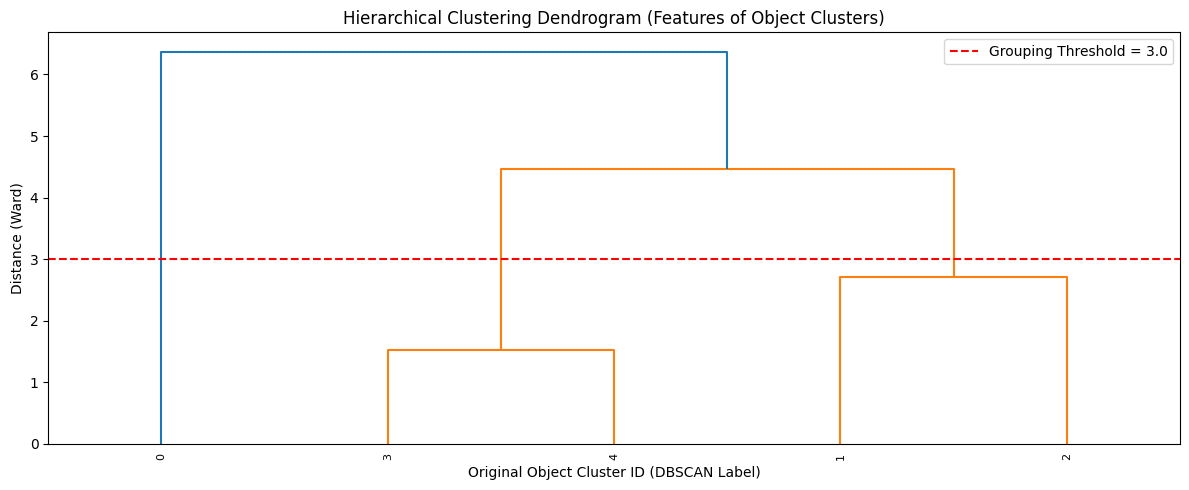


Applying Agglomerative Clustering with distance_threshold = 3.0...
Found 3 distinct object groups.
  Initial Cluster 0 assigned to Similarity Group 1
  Initial Cluster 1 assigned to Similarity Group 0
  Initial Cluster 2 assigned to Similarity Group 0
  Initial Cluster 3 assigned to Similarity Group 2
  Initial Cluster 4 assigned to Similarity Group 2

--- Visualizing Object Clusters Colored by Similarity Group (3 groups found) ---


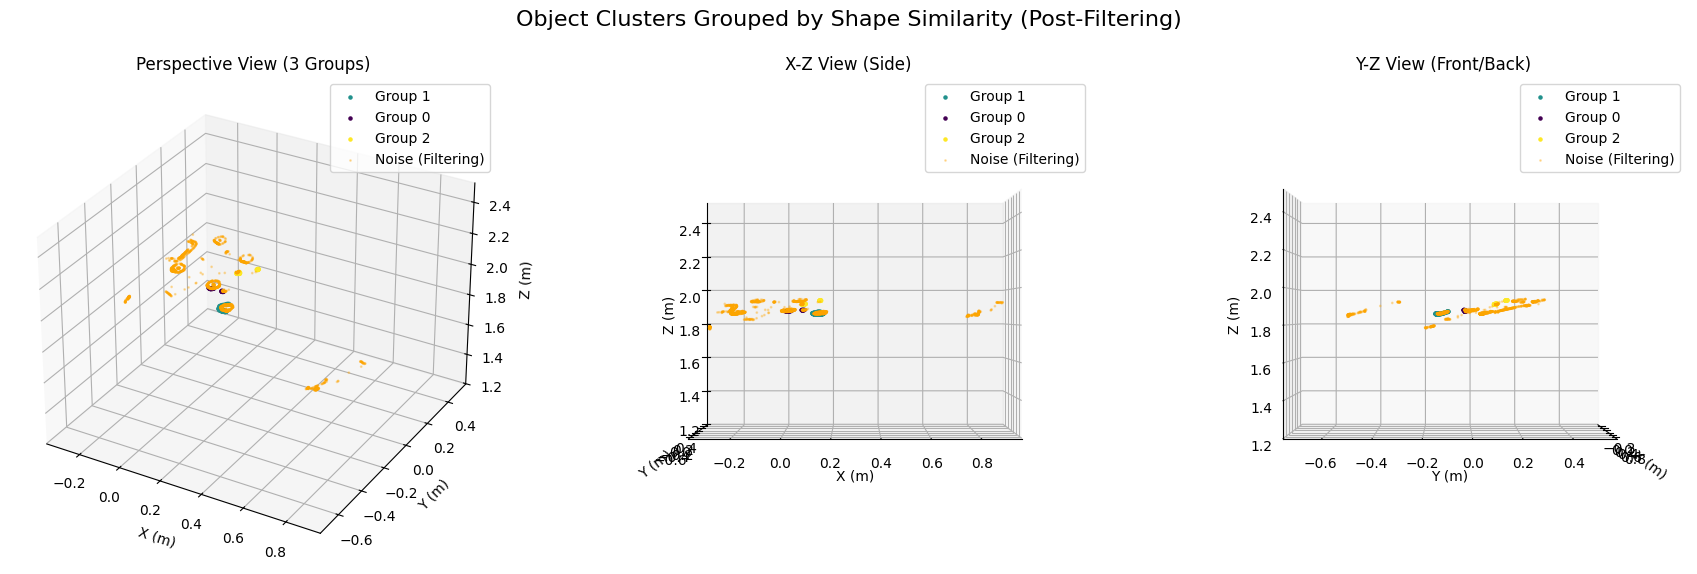

In [8]:
%pip install open3d


import numpy as np
import matplotlib.pyplot as plt
import cv2 # For dilation/erosion
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import open3d as o3d # Import Open3D for outlier removal

# --- Assume variables from previous cells are available ---
# selected_plane: Dictionary with info about the chosen tray plane (ID, params, mask, etc.)
# depth: The original depth image
# K: Camera intrinsics matrix
# inlier_threshold_meters: RANSAC threshold

# Initialize variables
object_points_3d = np.empty((0, 3))
filtered_object_points_3d = np.empty((0, 3))
noise_points_filtering = np.empty((0, 3))
cluster_labels = np.array([])
unique_labels = set()
num_final_groups = 0
original_object_info_list = []

if selected_plane: # Proceed only if a tray plane was successfully selected
    print(f"\n--- Detecting Objects on Selected Plane (ID: {selected_plane['id']}) ---")

    # --- 1. Isolate Potential Object Points ---
    plane_params = selected_plane['params']
    plane_mask = selected_plane['mask']
    plane_a, plane_b, plane_c = plane_params

    search_v, search_u = np.where(plane_mask)
    depth_values_search = depth[search_v, search_u]

    valid_depth_mask_search = np.isfinite(depth_values_search) & (depth_values_search > 0)
    valid_search_u = search_u[valid_depth_mask_search]
    valid_search_v = search_v[valid_depth_mask_search]
    valid_depths_actual = depth_values_search[valid_depth_mask_search]

    depths_on_plane = plane_a * valid_search_u + plane_b * valid_search_v + plane_c
    height_above_plane_threshold = inlier_threshold_meters
    initial_object_points_mask_1d = (depths_on_plane - valid_depths_actual) > height_above_plane_threshold

    object_points_u = valid_search_u[initial_object_points_mask_1d]
    object_points_v = valid_search_v[initial_object_points_mask_1d]
    object_points_depth = valid_depths_actual[initial_object_points_mask_1d]

    num_potential_object_points = len(object_points_u)
    print(f"Found {num_potential_object_points} potential object points initially above the plane.")

    # Convert these potential points to 3D
    if num_potential_object_points > 0:
        fx = K[0, 0]; fy = K[1, 1]; cx = K[0, 2]; cy = K[1, 2]
        obj_X = (object_points_u - cx) * object_points_depth / fx
        obj_Y = (object_points_v - cy) * object_points_depth / fy
        obj_Z = object_points_depth
        object_points_3d = np.vstack((obj_X, obj_Y, obj_Z)).T

        # --- 1a. Filter points near the edge using Erosion ---
        print("Applying erosion filter to remove edge points...")
        # Erode the original plane mask slightly to define the 'core' area
        # Adjust kernel size/iterations for erosion amount
        core_mask = cv2.erode(plane_mask.astype(np.uint8),
                              kernel=np.ones((7,7), np.uint8), # Slightly larger kernel for more erosion
                              iterations=1).astype(bool)

        # Create a 2D mask matching the shape of `object_points_u/v` indicating which are inside the core
        core_indices_mask_2d = np.zeros(depth.shape, dtype=bool)
        core_indices_mask_2d[object_points_v, object_points_u] = True # Mark initial object point locations
        core_indices_mask_2d[~core_mask] = False # Remove points outside the eroded 'core' mask

        # Filter the 1D arrays based on which points remain in the core
        in_core_mask_1d = core_indices_mask_2d[object_points_v, object_points_u]
        num_removed_erosion = np.sum(~in_core_mask_1d)

        # Keep only points within the core area
        core_object_points_3d = object_points_3d[in_core_mask_1d]
        print(f"Removed {num_removed_erosion} points via erosion filter. {core_object_points_3d.shape[0]} points remaining.")

        # Store points removed by erosion (optional)
        erosion_noise_points = object_points_3d[~in_core_mask_1d]

        # --- 1b. Filter sparse points using Radius Outlier Removal ---
        if core_object_points_3d.shape[0] > 10: # Need points to filter
            print("Applying Radius Outlier Removal filter...")
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(core_object_points_3d)

            # ** ROR parameters - TUNE THESE **
            ror_nb_points = 10 # Minimum number of neighbors in radius
            ror_radius = 0.015 # Radius (meters) - e.g., 1.5 cm

            # Remove outliers
            cl, ind = pcd.remove_radius_outlier(nb_points=ror_nb_points, radius=ror_radius)

            # Get inlier points and noise points
            filtered_object_points_3d = core_object_points_3d[ind]
            radius_noise_points = core_object_points_3d[np.setdiff1d(np.arange(core_object_points_3d.shape[0]), ind)]

            num_removed_ror = core_object_points_3d.shape[0] - len(ind)
            print(f"Removed {num_removed_ror} points via Radius Outlier Removal. {filtered_object_points_3d.shape[0]} points remaining for clustering.")

            # Combine noise points from both steps (optional)
            noise_points_filtering = np.vstack((erosion_noise_points, radius_noise_points)) if erosion_noise_points.shape[0] > 0 else radius_noise_points

        else:
            print("Skipping Radius Outlier Removal: Not enough points remaining after erosion.")
            filtered_object_points_3d = core_object_points_3d # Use points after erosion
            noise_points_filtering = erosion_noise_points # Noise is only from erosion

    else:
        print("No potential object points found, skipping filtering and clustering.")


    # --- 2. Cluster FILTERED Object Points using DBSCAN ---
    # ** Use 'filtered_object_points_3d' from now on **
    if filtered_object_points_3d.shape[0] > 10:
        print("\nClustering FILTERED object points using DBSCAN...")
        # ** DBSCAN parameters - TUNE THESE **
        dbscan_eps = 0.02
        dbscan_min_samples = 20

        # ** Use filtered_object_points_3d here **
        db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(filtered_object_points_3d)
        cluster_labels = db.labels_ # Labels correspond to filtered_object_points_3d
        unique_labels = set(cluster_labels)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        num_noise_dbscan = np.sum(cluster_labels == -1)
        print(f"DBSCAN found {num_clusters} initial clusters and {num_noise_dbscan} DBSCAN noise points (from filtered set).")

    else:
        print("\nNot enough points remaining after filtering for DBSCAN clustering.")

    # --- 3. Extract Features and Group Clusters by Shape Similarity ---
    if len(unique_labels) > 1 and np.any(cluster_labels != -1): # Proceed if DBSCAN found clusters
        print(f"\n--- Grouping {num_clusters} Detected Object Clusters by Shape Similarity ---")
        object_features_list = []
        original_object_info_list = []

        print("Extracting features for similarity grouping...")
        for k in unique_labels:
            if k == -1: continue

            cluster_mask = (cluster_labels == k)
            # ** Get points from filtered_object_points_3d **
            cluster_points = filtered_object_points_3d[cluster_mask]
            num_cluster_points = cluster_points.shape[0]

            MIN_POINTS_FOR_GROUPING = 20
            if num_cluster_points < MIN_POINTS_FOR_GROUPING:
                print(f"  Initial Cluster {k} too small ({num_cluster_points} points), skipping for grouping.")
                continue

            print(f"  Processing Initial Cluster {k} ({num_cluster_points} points)...")
            try:
                pca = PCA(n_components=3)
                pca.fit(cluster_points)
                points_transformed = pca.transform(cluster_points)
                min_coords_pca = np.min(points_transformed, axis=0)
                max_coords_pca = np.max(points_transformed, axis=0)
                obb_dimensions = max_coords_pca - min_coords_pca

                sorted_obb_dims = sorted(obb_dimensions, reverse=True)
                sorted_variance_ratios = sorted(pca.explained_variance_ratio_, reverse=True)
                feature_vector = [
                    sorted_obb_dims[0], sorted_obb_dims[1], sorted_obb_dims[2],
                    sorted_variance_ratios[0], sorted_variance_ratios[1], sorted_variance_ratios[2],
                    num_cluster_points
                ]
                object_features_list.append(feature_vector)
                original_object_info_list.append({
                    'original_id': k, # DBSCAN label for this cluster
                    'points': cluster_points,
                    'features_raw': feature_vector
                })
                # print(f"    Features: OBB={sorted_obb_dims}, VarRatio={sorted_variance_ratios}, Pts={num_cluster_points}") # Optional detailed print

            except Exception as e:
                print(f"    Feature extraction failed for cluster {k}: {e}")

        # --- Grouping based on features using Hierarchical Clustering ---
        if len(object_features_list) > 1:
            features_array = np.array(object_features_list)
            scaler = StandardScaler()
            features_normalized = scaler.fit_transform(features_array)
            print(f"\nNormalized feature vectors shape for grouping: {features_normalized.shape}")

            print("Calculating linkage matrix for dendrogram...")
            linkage_matrix = linkage(features_normalized, method='ward', metric='euclidean')

            # --- Plot Dendrogram ---
            plt.figure(figsize=(12, 5))
            plt.title('Hierarchical Clustering Dendrogram (Features of Object Clusters)')
            plt.xlabel('Original Object Cluster ID (DBSCAN Label)')
            plt.ylabel('Distance (Ward)')
            dendrogram(
                linkage_matrix,
                leaf_rotation=90.,
                leaf_font_size=8.,
                labels=[info['original_id'] for info in original_object_info_list]
            )
            # ** ADJUST THIS THRESHOLD BASED ON DENDROGRAM **
            CHOSEN_DISTANCE_THRESHOLD = 3.0
            plt.axhline(y=CHOSEN_DISTANCE_THRESHOLD, color='r', linestyle='--', label=f'Grouping Threshold = {CHOSEN_DISTANCE_THRESHOLD}')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # --- Perform Clustering ---
            print(f"\nApplying Agglomerative Clustering with distance_threshold = {CHOSEN_DISTANCE_THRESHOLD}...")
            agg_clustering = AgglomerativeClustering(
                n_clusters=None, distance_threshold=CHOSEN_DISTANCE_THRESHOLD,
                metric='euclidean', linkage='ward'
            )
            group_labels = agg_clustering.fit_predict(features_normalized)
            num_final_groups = len(set(group_labels))
            print(f"Found {num_final_groups} distinct object groups.")

            # Assign group labels back
            for i, obj_info in enumerate(original_object_info_list):
                obj_info['group_id'] = group_labels[i]
                print(f"  Initial Cluster {obj_info['original_id']} assigned to Similarity Group {obj_info['group_id']}")

        elif len(object_features_list) == 1:
            print("\nOnly one valid object cluster found after filtering, assigning to Group 0.")
            original_object_info_list[0]['group_id'] = 0
            num_final_groups = 1
        else:
            print("\nNo valid object clusters remaining after filtering for grouping.")
            num_final_groups = 0

    # --- Handle cases where DBSCAN found only one cluster or only noise ---
    elif len(unique_labels) == 1 and -1 not in unique_labels:
         print("\nOnly one initial cluster found by DBSCAN (after filtering), assigning to Group 0.")
         k = list(unique_labels)[0]
         cluster_mask = (cluster_labels == k)
         cluster_points = filtered_object_points_3d[cluster_mask]
         original_object_info_list.append({'original_id': k, 'points': cluster_points, 'group_id': 0})
         num_final_groups = 1
    else:
        print("\nNo initial clusters found by DBSCAN or insufficient data for grouping.")
        num_final_groups = 0

    # --- 4. Visualization Based on New Groups (Multiple Perspectives) ---
    print(f"\n--- Visualizing Object Clusters Colored by Similarity Group ({num_final_groups} groups found) ---")
    fig_groups, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})
    if num_final_groups == 0 and noise_points_filtering.shape[0] == 0 and not np.any(cluster_labels == -1) :
         print("No data points (groups or noise) to visualize.")
         plt.close(fig_groups)
    else:
        axes = axes.flatten()
        group_colors = plt.cm.viridis(np.linspace(0, 1, num_final_groups)) if num_final_groups > 0 else []

        # --- Define data plotting function ---
        def plot_data_on_ax(ax):
            plotted_groups = set()
            # Plot grouped clusters
            if num_final_groups > 0:
                for obj_info in original_object_info_list:
                    points = obj_info['points']
                    group_id = obj_info['group_id']
                    color = group_colors[group_id % num_final_groups]
                    label = f"Group {group_id}" if group_id not in plotted_groups else None
                    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=color, s=5, label=label)
                    plotted_groups.add(group_id)

            # Plot noise points removed by initial filtering (erosion + ROR)
            if noise_points_filtering.shape[0] > 0:
                ax.scatter(noise_points_filtering[:, 0], noise_points_filtering[:, 1], noise_points_filtering[:, 2],
                           c='orange', s=1, alpha=0.3, label='Noise (Filtering)')

            # Plot noise points found by DBSCAN (from the filtered set)
            if np.any(cluster_labels == -1):
                 # ** Get noise points from filtered_object_points_3d **
                 dbscan_noise_points = filtered_object_points_3d[cluster_labels == -1]
                 if dbscan_noise_points.shape[0] > 0:
                     ax.scatter(dbscan_noise_points[:, 0], dbscan_noise_points[:, 1], dbscan_noise_points[:, 2],
                               c='magenta', s=1, alpha=0.3, label='Noise (DBSCAN)')

            ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')

            # Set axis limits based on all points (initial potential points) for consistent scale
            min_coords = np.array([np.inf, np.inf, np.inf])
            max_coords = np.array([-np.inf, -np.inf, -np.inf])
            has_points = False
            if object_points_3d.shape[0] > 0: # Use original potential points for bounds
                 min_coords = np.min(object_points_3d, axis=0)
                 max_coords = np.max(object_points_3d, axis=0)
                 has_points = True

            if has_points:
                center = (min_coords + max_coords) / 2.0
                max_range = (max_coords - min_coords).max() / 2.0 + 0.05
                ax.set_xlim(center[0] - max_range, center[0] + max_range)
                ax.set_ylim(center[1] - max_range, center[1] + max_range)
                ax.set_zlim(center[2] - max_range, center[2] + max_range)
            else:
                ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(1, 3)

            # Collect legend handles and labels
            handles, labels = ax.get_legend_handles_labels()
            # Create unique legend
            by_label = dict(zip(labels, handles))
            if by_label: # Show legend only if there's something to label
                ax.legend(by_label.values(), by_label.keys())
        # --- End of plotting function ---

        # --- Plot on each subplot with different views ---
        plot_data_on_ax(axes[0]); axes[0].set_title(f"Perspective View ({num_final_groups} Groups)")
        plot_data_on_ax(axes[1]); axes[1].set_title("X-Z View (Side)"); axes[1].view_init(elev=0, azim=-90)
        plot_data_on_ax(axes[2]); axes[2].set_title("Y-Z View (Front/Back)"); axes[2].view_init(elev=0, azim=0)

        fig_groups.suptitle(f"Object Clusters Grouped by Shape Similarity (Post-Filtering)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

else:
    print("No plane was selected in the previous step. Cannot detect objects.")

